## Packages

In [ ]:
!git clone https://github.com/OSUPCVLab/SegFormer3D.git
%cd SegFormer3D

!pip install -r requirements.txt
!pip install monai accelerate termcolor

In [7]:
import os
import glob
import random
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from monai.transforms import Transform, MapTransform

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Adjust SegFormer3D package to handle BraTs 2023 data

In [6]:
!mkdir -p /content/SegFormer3D/data/brats2023_seg/BraTS2023_Processed_Data
!mkdir -p /content/SegFormer3D/data/brats2023_seg/brats2023_raw_data
!mkdir -p /content/SegFormer3D/experiments/brats_2023/my_experiment

In [27]:
%%writefile /content/SegFormer3D/data/brats2023_seg/brats2023_raw_data/brats2023_seg_preprocess.py
import os
import torch
import nibabel as nib
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from monai.transforms import Orientation, EnsureType, Transform, MapTransform
from monai.utils.enums import TransformBackends
from monai.config.type_definitions import NdarrayOrTensor
from multiprocessing import Pool


class ConvertToMultiChannelBasedOnBrats2023Classes(Transform):
    """
    Convert labels to multi channels based on BraTS 2023 classes:
    label 1 is the Nonenhancing Tumor Core (NETC)
    label 2 is the Surrounding Non-Enhancing FLAIR Hyperintensity (SNFH)
    label 3 is the Enhancing Tumor (ET)
    """

    backend = [TransformBackends.TORCH, TransformBackends.NUMPY]

    def __call__(self, img):
        # if img has channel dim, squeeze it
        if img.ndim == 4 and img.shape[0] == 1:
            img = img.squeeze(0)

        result = [
            (img == 1),  # NETC
            (img == 2),  # SNFH
            (img == 3)   # ET
        ]
        return torch.stack(result, dim=0) if isinstance(img, torch.Tensor) else np.stack(result, axis=0)


class Brats2023Preprocess:
    def __init__(self, root_dir, save_dir="/content/drive/MyDrive/BraTs/BraTS2023_Processed_Data"):
        self.root_dir = root_dir
        self.save_dir = save_dir
        self.MRI_TYPE = ["t1n", "t1c", "t2f", "t2w", "seg"]
        self.case_names = next(os.walk(self.root_dir), (None, None, []))[1]
        assert len(self.case_names) > 0, "No cases found in the directory!"

    def normalize(self, x):
        scaler = MinMaxScaler()
        normalized = scaler.fit_transform(x.reshape(-1, x.shape[-1])).reshape(x.shape)
        return normalized

    def load_nifti(self, filepath):
        nifti_data = nib.load(filepath)
        data = nifti_data.get_fdata()
        affine = nifti_data.affine
        return data, affine

    def preprocess_modality(self, filepath, is_label=False):
        data, affine = self.load_nifti(filepath)
        if is_label:
            data = data.astype(np.uint8)
            data = ConvertToMultiChannelBasedOnBrats2023Classes()(data)  # Use custom transform class
        else:
            data = self.normalize(data)
            data = data[np.newaxis, ...]

        data = Orientation(axcodes="RAS")(EnsureType()(data))
        return data

    def process_case(self, case_name):
        case_dir = os.path.join(self.root_dir, case_name)
        save_case_dir = os.path.join(self.save_dir, case_name)
        os.makedirs(save_case_dir, exist_ok=True)

        modalities = []
        for mri_type in self.MRI_TYPE[:-1]:
            filepath = os.path.join(case_dir, f"{case_name}-{mri_type}.nii")
            modality_data = self.preprocess_modality(filepath, is_label=False)
            modalities.append(modality_data)

        label_filepath = os.path.join(case_dir, f"{case_name}-seg.nii")
        label_data = self.preprocess_modality(label_filepath, is_label=True)

        modalities = np.concatenate(modalities, axis=0)
        torch.save(modalities, os.path.join(save_case_dir, f"{case_name}_modalities.pt"))
        torch.save(label_data, os.path.join(save_case_dir, f"{case_name}_label.pt"))

    def preprocess(self):
        with Pool() as pool:
            pool.map(self.process_case, self.case_names)

if __name__ == "__main__":
    preprocessor = Brats2023Preprocess(root_dir="/content/drive/MyDrive/BraTs/brats2023-training")
    preprocessor.preprocess()

Overwriting /content/SegFormer3D/data/brats2023_seg/brats2023_raw_data/brats2023_seg_preprocess.py


In [11]:
%%writefile /content/SegFormer3D/dataloaders/brats2023_seg.py
import os
import torch
import pandas as pd
from torch.utils.data import Dataset

class Brats2023Dataset(Dataset):
    def __init__(self, root_dir, is_train=True, transform=None, fold_id=None):
        super().__init__()
        csv_name = "train.csv" if is_train else "validation.csv"
        csv_fp = os.path.join(root_dir, csv_name)
        assert os.path.exists(csv_fp), f"CSV file not found: {csv_fp}"

        self.csv = pd.read_csv(csv_fp)
        self.transform = transform

    def __len__(self):
        return len(self.csv)

    def __getitem__(self, idx):
        data_path = self.csv["data_path"][idx]
        case_name = self.csv["case_name"][idx]

        volume_fp = os.path.join(data_path, f"{case_name}_modalities.pt")
        label_fp = os.path.join(data_path, f"{case_name}_label.pt")

        volume = torch.tensor(torch.load(volume_fp)).float()
        label = torch.tensor(torch.load(label_fp)).float()

        data = {"image": volume, "label": label}

        if self.transform:
            data = self.transform(data)

        return data

Writing /content/SegFormer3D/dataloaders/brats2023_seg.py


In [12]:
%%writefile /content/SegFormer3D/dataloaders/build_dataset.py
import sys
from typing import Dict
from monai.data import DataLoader
from augmentations.augmentations import build_augmentations

def build_dataset(dataset_type: str, dataset_args: Dict):
    if dataset_type == "brats2023_seg":
        from .brats2023_seg import Brats2023Dataset
        dataset = Brats2023Dataset(
            root_dir=dataset_args["root"],
            is_train=dataset_args["train"],
            transform=build_augmentations(dataset_args["train"]),
            fold_id=dataset_args["fold_id"],
        )
        return dataset
    else:
        raise ValueError("only brats2023 segmentation is currently supported!")

def build_dataloader(dataset, dataloader_args: Dict, config: Dict = None, train: bool = True) -> DataLoader:
    dataloader = DataLoader(
        dataset=dataset,
        batch_size=dataloader_args["batch_size"],
        shuffle=dataloader_args["shuffle"],
        num_workers=dataloader_args["num_workers"],
        drop_last=dataloader_args["drop_last"],
        pin_memory=True,
    )
    return dataloader

Overwriting /content/SegFormer3D/dataloaders/build_dataset.py


In [41]:
%%writefile /content/SegFormer3D/experiments/brats_2023/my_experiment/config.yaml
# wandb parameters
project: segfmr3d
wandb_parameters:
  mode: "offline" # set this to "online" if you want to log to wandb
  entity: pcvlab
  group: brats2023
  name: segformer3d_adamw_batch2_diceloss
  resume: False
  tags: ["pcvlab", "dice", "b0_model", "adamw"]

# model parameters
model_name: segformer3d
model_parameters:
  in_channels: 4
  sr_ratios: [4, 2, 1, 1]
  embed_dims: [32, 64, 160, 256]
  patch_kernel_size: [7, 3, 3, 3]
  patch_stride: [4, 2, 2, 2]
  patch_padding: [3, 1, 1, 1]
  mlp_ratios: [4, 4, 4, 4]
  num_heads: [1, 2, 5, 8]
  depths: [2, 2, 2, 2]
  num_classes: 3
  decoder_dropout: 0.0
  decoder_head_embedding_dim: 256

# loss function
loss_fn:
  loss_type: "dice"
  loss_args: None

# optimizer
optimizer:
  optimizer_type: "adamw"
  optimizer_args:
    lr: 0.0001
    weight_decay: 0.01

# schedulers
warmup_scheduler:
  enabled: True # should be always true
  warmup_epochs: 20

train_scheduler:
  scheduler_type: 'cosine_annealing_wr'
  scheduler_args:
    t_0_epochs: 400
    t_mult: 1
    min_lr: 0.000006

# (Not fully implemented yet) exponential moving average
ema:
  enabled: False
  ema_decay: 0.999
  val_ema_every: 1

sliding_window_inference:
  sw_batch_size: 4
  roi: [128, 128, 128]

# gradient clipping (not implemented yet)
clip_gradients:
  enabled: False
  clip_gradients_value: 0.1

# training hyperparameters
training_parameters:
  seed: 42
  num_epochs: 800
  cutoff_epoch: 400
  load_optimizer: False
  print_every: 200
  calculate_metrics: True
  grad_accumulate_steps: 4 # default: 1
  checkpoint_save_dir: "model_checkpoints/best_dice_checkpoint"
  load_checkpoint: # not implemented yet
    load_full_checkpoint: False
    load_model_only: False
    load_checkpoint_path: None

# dataset args
dataset_parameters:
  dataset_type: "brats2023_seg"
  train_dataset_args:
    root: "../../../data/brats2023_seg"
    train: True
    fold_id: null

  val_dataset_args:
    root: "../../../data/brats2023_seg"
    train: False
    fold_id: null

  train_dataloader_args:
    batch_size: 4
    shuffle: True
    num_workers: 8
    drop_last: True

  val_dataloader_args:
    batch_size: 2
    shuffle: False
    num_workers: 6
    drop_last: False

Overwriting /content/SegFormer3D/experiments/brats_2023/my_experiment/config.yaml


## Data preparation

### Pre-process data

In [30]:
!python /content/SegFormer3D/data/brats2023_seg/brats2023_raw_data/brats2023_seg_preprocess.py

2024-07-09 14:45:06.454717: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-09 14:45:06.454774: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-09 14:45:06.456961: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-09 14:45:07.504585: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


### Visualize data

Shape of label tensor: torch.Size([3, 240, 240, 155])
Unique classes in label tensor: metatensor([False,  True])


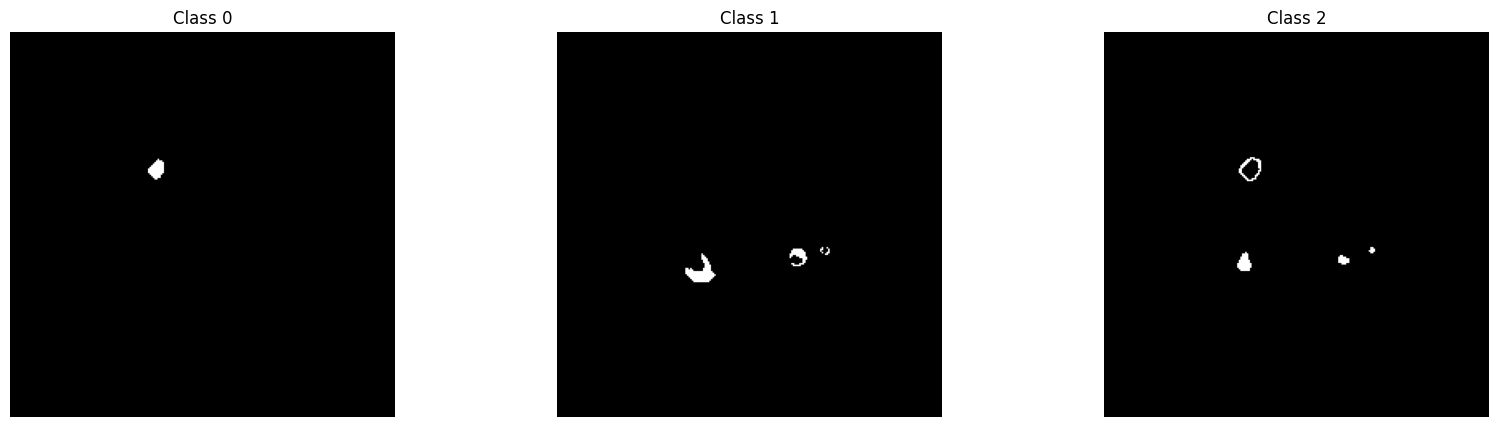

In [39]:
# Function to load a sample case and check the labels
def check_preprocessed_labels(case_dir, case_name):
    label_fp = os.path.join(case_dir, f"{case_name}/{case_name}_label.pt")
    label = torch.load(label_fp)

    print("Shape of label tensor:", label.shape)
    unique_classes = torch.unique(label)
    print("Unique classes in label tensor:", unique_classes)

    return label

# Visualize the labels for a specific slice
def visualize_labels(label_tensor, slice_idx=70):
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))
    for i in range(3):
        axes[i].imshow(label_tensor[i, :, :, slice_idx].numpy(), cmap='gray')
        axes[i].set_title(f'Class {i}')
        axes[i].axis('off')
    plt.show()

# Path to the preprocessed data directory and sample case name
processed_data_dir = '/content/drive/MyDrive/BraTs/BraTS2023_Processed_Data'
sample_case_name = 'BraTS-MET-00024-000'

# Check and visualize the labels
label_tensor = check_preprocessed_labels(processed_data_dir, sample_case_name)
visualize_labels(label_tensor)

### Train-test-split

In [31]:
# Path to the processed data directory
processed_data_dir = '/content/drive/MyDrive/BraTs/BraTS2023_Processed_Data'

# Assume each folder in the processed data directory represents a case
cases = [d for d in os.listdir(processed_data_dir) if os.path.isdir(os.path.join(processed_data_dir, d))]

# Split cases into train and validation (e.g., 80-20 split)
train_cases = cases[:int(len(cases) * 0.8)]
val_cases = cases[int(len(cases) * 0.8):]

# Create DataFrames
train_df = pd.DataFrame({'data_path': [os.path.join(processed_data_dir, c) for c in train_cases], 'case_name': train_cases})
val_df = pd.DataFrame({'data_path': [os.path.join(processed_data_dir, c) for c in val_cases], 'case_name': val_cases})

# Save to CSV
train_df.to_csv('/content/SegFormer3D/data/brats2023_seg/train.csv', index=False)
val_df.to_csv('/content/SegFormer3D/data/brats2023_seg/validation.csv', index=False)

## Training

In [ ]:
!pip install safetensors>=0.4.1
!pip install transformers -U

In [42]:
%cd /content/SegFormer3D/experiments/brats_2023/my_experiment/
!accelerate launch --config_file ./gpu_accelerate.yaml run_experiment.py

/content/SegFormer3D/experiments/brats_2023/my_experiment
2024-07-09 15:26:47.323597: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-09 15:26:47.323648: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-09 15:26:47.328292: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-09 15:26:48.426965: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
wandb: Tracking run with wandb version 0.15.12
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


## Evaluation

## Visualizing results